<a href="https://colab.research.google.com/github/xtianu/CV_Tirana/blob/main/M4_Deep%20Learning/p1_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MODULE 4: DEEP LEARNING

Christian Mata, PhD

##### Copyright 2019 The TensorFlow Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# PART 1: Image segmentation

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/images/segmentation">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/segmentation.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/segmentation.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/images/segmentation.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial focuses on the task of image segmentation, using a modified <a href="https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/" class="external">U-Net</a>.

## What is image segmentation?

In an image classification task, the network assigns a label (or class) to each input image. However, suppose you want to know the shape of that object, which pixel belongs to which object, etc. In this case, you need to assign a class to each pixel of the image—this task is known as segmentation. A segmentation model returns much more detailed information about the image. Image segmentation has many applications in medical imaging, self-driving cars and satellite imaging, just to name a few.

This tutorial uses the [Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/) ([Parkhi et al, 2012](https://www.robots.ox.ac.uk/~vgg/publications/2012/parkhi12a/parkhi12a.pdf)). The dataset consists of images of 37 pet breeds, with 200 images per breed (~100 each in the training and test splits). Each image includes the corresponding labels, and pixel-wise masks. The masks are class-labels for each pixel. Each pixel is given one of three categories:

- Class 1: Pixel belonging to the pet.
- Class 2: Pixel bordering the pet.
- Class 3: None of the above/a surrounding pixel.

In [1]:
!pip install git+https://github.com/tensorflow/examples.git
!pip install -U keras
!pip install -q tensorflow_datasets
!pip install -q -U tensorflow-text tensorflow

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-lh4m23a9
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /tmp/pip-req-build-lh4m23a9
  Resolved https://github.com/tensorflow/examples.git to commit 3c7435733a9162481df350e57c53e58d2a705e4d
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-examples: filename=tensorflow_examples-0.1746868094.345130988853936603129253091149118257392589495885-py3-none-any.whl size=301646 sha256=784051aca2b4bc78ca50bccfb8584425cad903b380b2fa87d44684888abcbf17
  Stored in directory: /tmp/pip-ephem-wheel-cache-vd4jgeiz/wheels/91/9b/e8/6ae2ecc930bd726c578e35b313e987a687bc5ce03c3a42c2d5
Successfully built tensorflow-examples
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 12.8 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.8.0
    Uninstalling keras-3.8.0:
      Successfully uninstalled keras-3.8.0
   ━━━━━━━━━━━━━━━━━━

In [2]:
import numpy as np

import tensorflow as tf
import tensorflow_datasets as tfds

In [5]:
from tensorflow_examples.models.pix2pix import pix2pix

from IPython.display import clear_output
import matplotlib.pyplot as plt

## Download the Oxford-IIIT Pets dataset

The dataset is [available from TensorFlow Datasets](https://www.tensorflow.org/datasets/catalog/oxford_iiit_pet). The segmentation masks are included in version 3+.

In [11]:
import tensorflow_datasets as tfds

dataset, info = tfds.load('oxford_iiit_pet:4.0.0', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.NZTSPG_4.0.0/oxford_iiit_pet-train.tfrecord*...…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.NZTSPG_4.0.0/oxford_iiit_pet-test.tfrecord*...:…

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/4.0.0. Subsequent calls will reuse this data.


 In addition, the image color values are normalized to the `[0, 1]` range. Finally, as mentioned above the pixels in the segmentation mask are labeled either {1, 2, 3}. For the sake of convenience, subtract 1 from the segmentation mask, resulting in labels that are : {0, 1, 2}.

In [12]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [13]:
def load_image(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(
    datapoint['segmentation_mask'],
    (128, 128),
    method = tf.image.ResizeMethod.NEAREST_NEIGHBOR,
  )

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

The dataset already contains the required training and test splits, so continue to use the same splits:

In [14]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [19]:
train_images = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

The following class performs a simple augmentation by randomly-flipping an image.
Go to the [Image augmentation](data_augmentation.ipynb) tutorial to learn more.


In [20]:
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

Build the input pipeline, applying the augmentation after batching the inputs:

In [21]:
train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_images.batch(BATCH_SIZE)

Visualize an image example and its corresponding mask from the dataset:

In [22]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

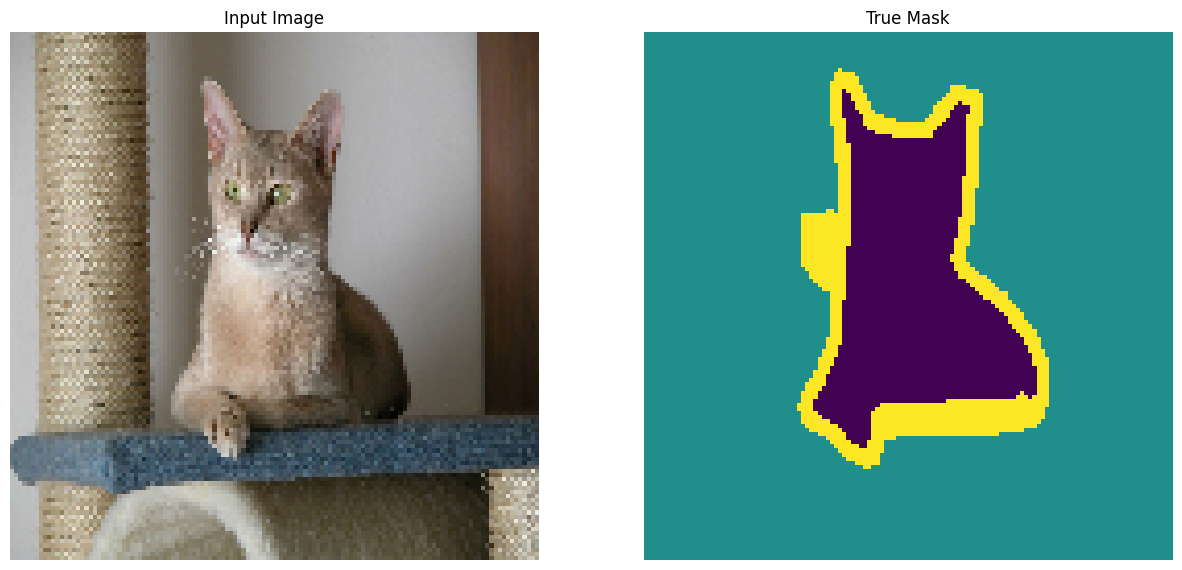

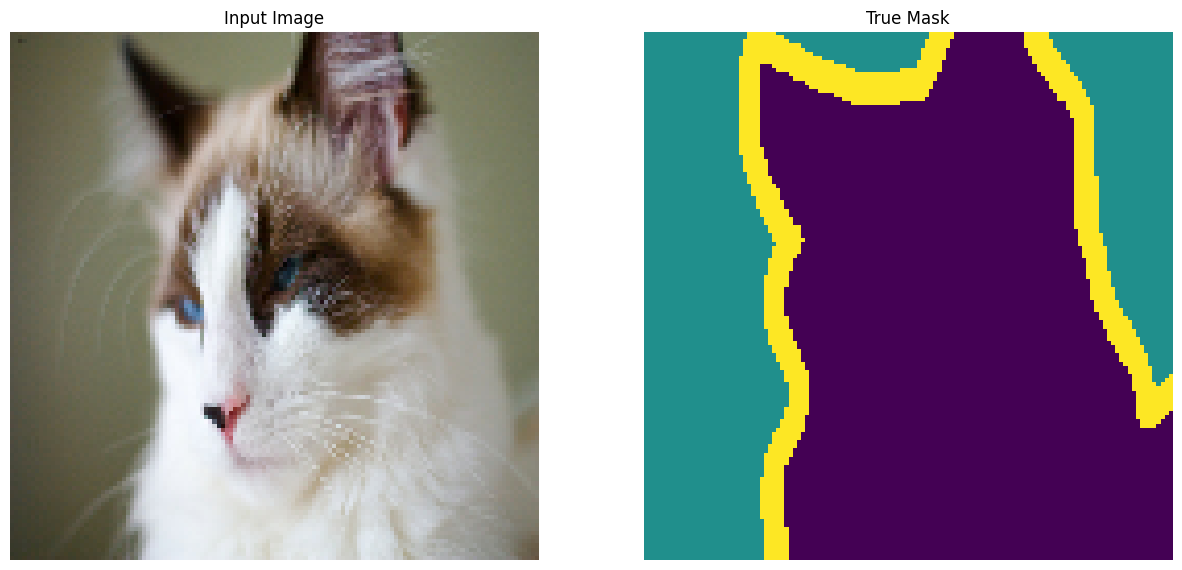

In [24]:
for images, masks in train_batches.take(2):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])

## Define the model
The model being used here is a modified [U-Net](https://arxiv.org/abs/1505.04597). A U-Net consists of an encoder (downsampler) and decoder (upsampler). To learn robust features and reduce the number of trainable parameters, use a pretrained model—[MobileNetV2](https://arxiv.org/abs/1801.04381)—as the encoder. For the decoder, you will use the upsample block, which is already implemented in the [pix2pix](https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/pix2pix/pix2pix.py) example in the TensorFlow Examples repo. (Check out the [pix2pix: Image-to-image translation with a conditional GAN](../generative/pix2pix.ipynb) tutorial in a notebook.)


As mentioned, the encoder is a pretrained MobileNetV2 model. You will use the model from `tf.keras.applications`. The encoder consists of specific outputs from intermediate layers in the model. Note that the encoder will not be trained during the training process.

In [25]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


The decoder/upsampler is simply a series of upsample blocks implemented in TensorFlow examples:

In [26]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [27]:
def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

Note that the number of filters on the last layer is set to the number of `output_channels`. This will be one output channel per class.

## Train the model

Now, all that is left to do is to compile and train the model.

Since this is a multiclass classification problem, use the `tf.keras.losses.SparseCategoricalCrossentropy` loss function with the `from_logits` argument set to `True`, since the labels are scalar integers instead of vectors of scores for each pixel of every class.

When running inference, the label assigned to the pixel is the channel with the highest value. This is what the `create_mask` function is doing.

In [28]:
OUTPUT_CLASSES = 3

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Plot the resulting model architecture:

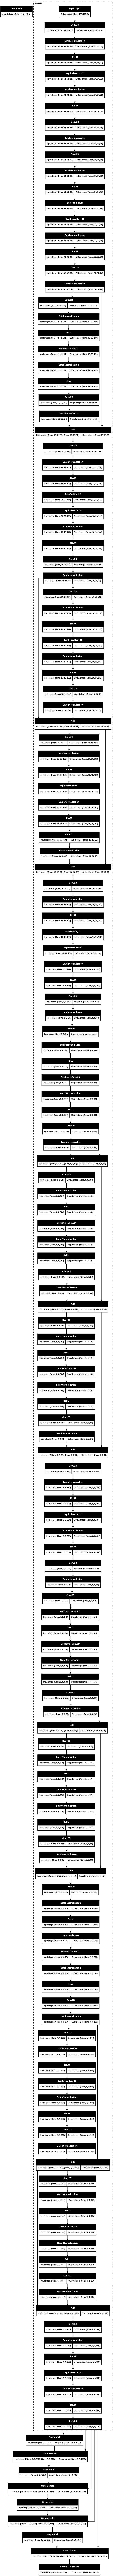

In [29]:
tf.keras.utils.plot_model(model, show_shapes=True, expand_nested=True, dpi=64)

Try out the model to check what it predicts before training:

In [30]:
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [31]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


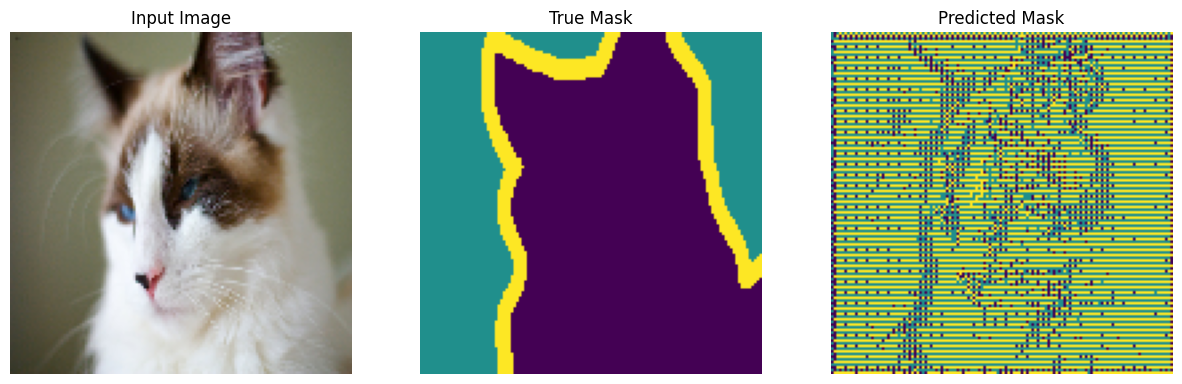

In [32]:
show_predictions()

The callback defined below is used to observe how the model improves while it is training:

In [33]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


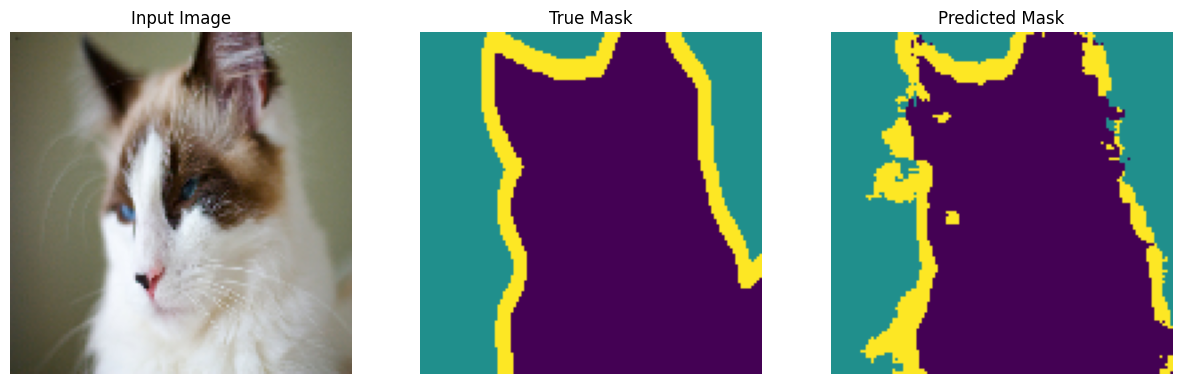


Sample Prediction after epoch 20

57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 145ms/step - accuracy: 0.9284 - loss: 0.1753 - val_accuracy: 0.9029 - val_loss: 0.2733


In [34]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches,
                          callbacks=[DisplayCallback()])

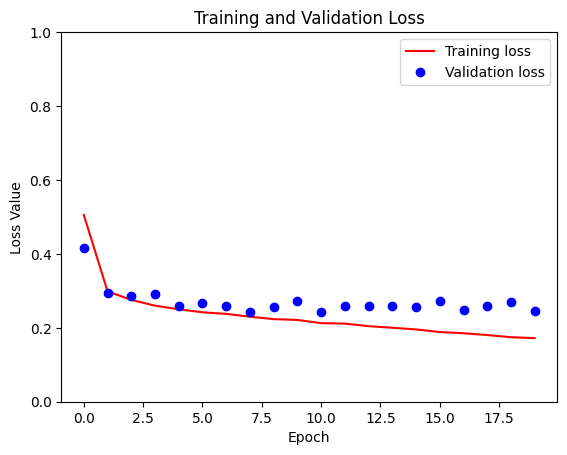

In [ ]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

## Make predictions

Now, make some predictions. In the interest of saving time, the number of epochs was kept small, but you may set this higher to achieve more accurate results.

1/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step


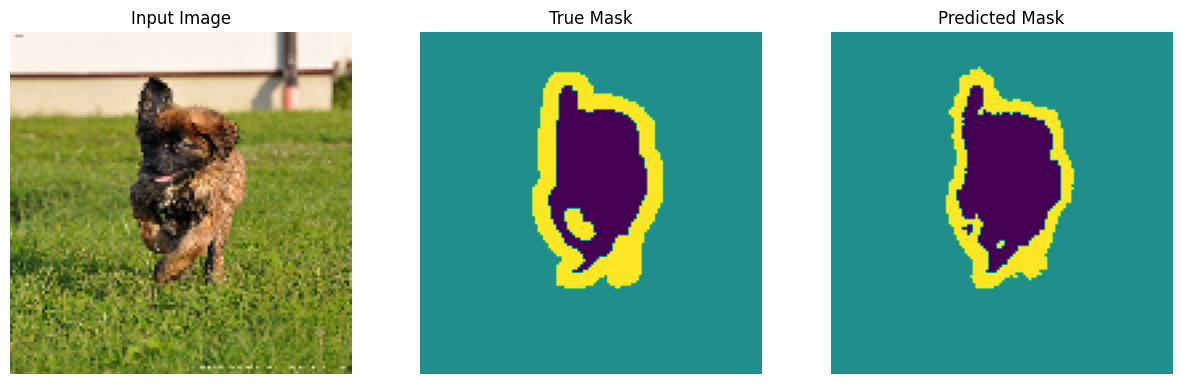

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


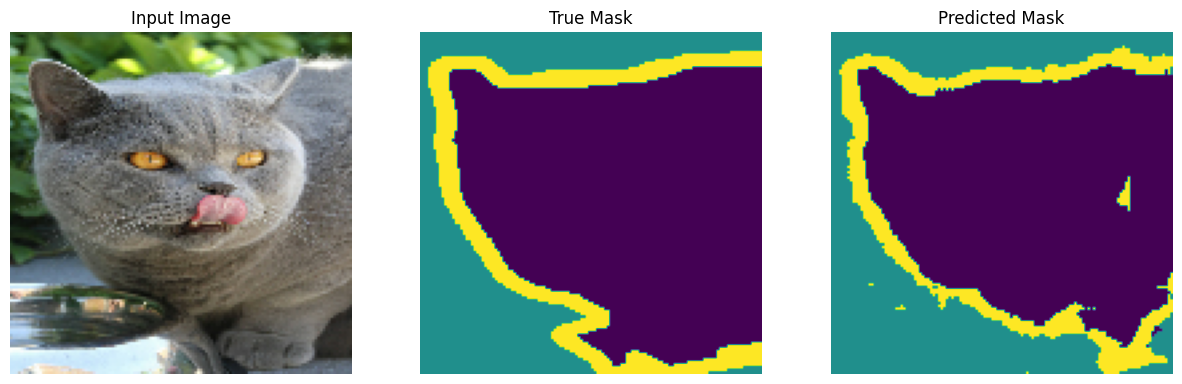

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


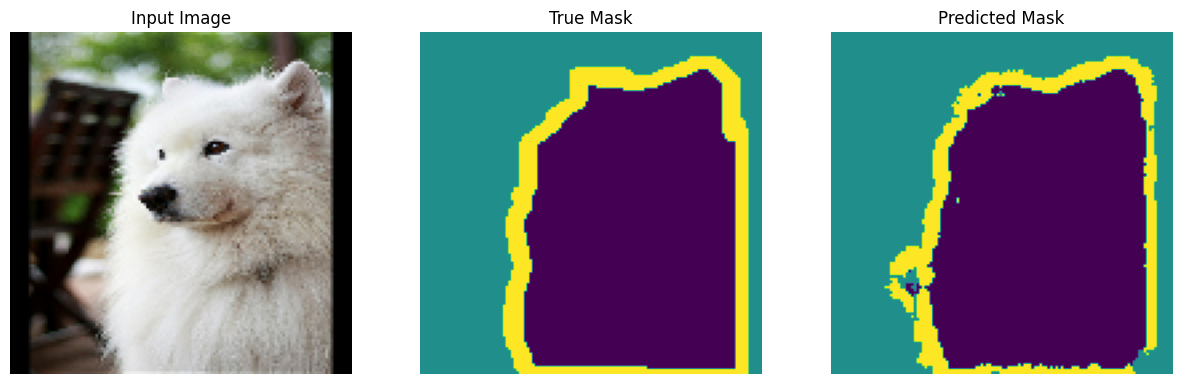

In [ ]:
show_predictions(test_batches, 3)

## Optional: Imbalanced classes and class weights

Semantic segmentation datasets can be highly imbalanced meaning that particular class pixels can be present more inside images than that of other classes. Since segmentation problems can be treated as per-pixel classification problems, you can deal with the imbalance problem by weighing the loss function to account for this. It's a simple and elegant way to deal with this problem. Refer to the [Classification on imbalanced data](../structured_data/imbalanced_data.ipynb) tutorial to learn more.

To [avoid ambiguity](https://github.com/keras-team/keras/issues/3653#issuecomment-243939748), `Model.fit` does not support the `class_weight` argument for targets with 3+ dimensions.

In [ ]:
try:
  model_history = model.fit(train_batches, epochs=EPOCHS,
                            steps_per_epoch=STEPS_PER_EPOCH,
                            class_weight = {0:2.0, 1:2.0, 2:1.0})
  assert False
except Exception as e:
  print(f"Expected {type(e).__name__}: {e}")

Epoch 1/20


W0000 00:00:1723778113.501185  129000 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


 1/57 ━━━━━━━━━━━━━━━━━━━━ 6:33 7s/step - accuracy: 0.9352 - loss: 0.2474

 2/57 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 0.9338 - loss: 0.2455

 3/57 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 0.9330 - loss: 0.2418

 4/57 ━━━━━━━━━━━━━━━━━━━━ 6s 119ms/step - accuracy: 0.9318 - loss: 0.2404

 5/57 ━━━━━━━━━━━━━━━━━━━━ 6s 118ms/step - accuracy: 0.9310 - loss: 0.2390

 6/57 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - accuracy: 0.9305 - loss: 0.2382

 7/57 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - accuracy: 0.9302 - loss: 0.2377

 8/57 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - accuracy: 0.9300 - loss: 0.2373

 9/57 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - accuracy: 0.9299 - loss: 0.2370

10/57 ━━━━━━━━━━━━━━━━━━━━ 5s 114ms/step - accuracy: 0.9297 - loss: 0.2370

11/57 ━━━━━━━━━━━━━━━━━━━━ 5s 114ms/step - accuracy: 0.9294 - loss: 0.2372

12/57 ━━━━━━━━━━━━━━━━━━━━ 5s 114ms/step - accuracy: 0.9293 - loss: 0.2372

13/57 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 0.9291 - loss: 0.2373

14/57 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 0.9289 - loss: 0.2376

15/57 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 0.9288 - loss: 0.2379

16/57 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 0.9286 - loss: 0.2381

17/57 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 0.9285 - loss: 0.2384

18/57 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 0.9284 - loss: 0.2387

19/57 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 0.9282 - loss: 0.2390

20/57 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 0.9281 - loss: 0.2394

21/57 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 0.9280 - loss: 0.2397

22/57 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 0.9278 - loss: 0.2401

23/57 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 0.9277 - loss: 0.2404

24/57 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 0.9276 - loss: 0.2408

25/57 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 0.9275 - loss: 0.2412

26/57 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 0.9273 - loss: 0.2415

27/57 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 0.9272 - loss: 0.2419

28/57 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 0.9271 - loss: 0.2422

29/57 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 0.9270 - loss: 0.2426

30/57 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 0.9269 - loss: 0.2429

31/57 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 0.9268 - loss: 0.2433

32/57 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 0.9267 - loss: 0.2436

33/57 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 0.9266 - loss: 0.2439

34/57 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 0.9265 - loss: 0.2442

35/57 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 0.9264 - loss: 0.2446

36/57 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 0.9263 - loss: 0.2449

37/57 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 0.9262 - loss: 0.2452

38/57 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 0.9261 - loss: 0.2455

39/57 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 0.9260 - loss: 0.2458

40/57 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 0.9259 - loss: 0.2460

41/57 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 0.9259 - loss: 0.2463

42/57 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 0.9258 - loss: 0.2465

43/57 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 0.9257 - loss: 0.2468

44/57 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 0.9256 - loss: 0.2470

45/57 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 0.9256 - loss: 0.2472

46/57 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 0.9255 - loss: 0.2474

47/57 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 0.9254 - loss: 0.2476

48/57 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 0.9254 - loss: 0.2478

49/57 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.9253 - loss: 0.2480

50/57 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.9253 - loss: 0.2482

51/57 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.9252 - loss: 0.2484

52/57 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.9251 - loss: 0.2485

53/57 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.9251 - loss: 0.2487

54/57 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.9250 - loss: 0.2489

55/57 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.9250 - loss: 0.2490

56/57 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.9249 - loss: 0.2492

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.9249 - loss: 0.2493

57/57 ━━━━━━━━━━━━━━━━━━━━ 13s 113ms/step - accuracy: 0.9249 - loss: 0.2495


Epoch 2/20


W0000 00:00:1723778123.461684  129003 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


 1/57 ━━━━━━━━━━━━━━━━━━━━ 3:04 3s/step - accuracy: 0.9222 - loss: 0.2514

 2/57 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 0.9231 - loss: 0.2470

 3/57 ━━━━━━━━━━━━━━━━━━━━ 7s 137ms/step - accuracy: 0.9234 - loss: 0.2459

 4/57 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9238 - loss: 0.2449

 5/57 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 0.9237 - loss: 0.2454

 6/57 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 0.9237 - loss: 0.2458

 7/57 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - accuracy: 0.9237 - loss: 0.2463

 8/57 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 0.9236 - loss: 0.2471

 9/57 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - accuracy: 0.9235 - loss: 0.2477

10/57 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - accuracy: 0.9234 - loss: 0.2484

11/57 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - accuracy: 0.9234 - loss: 0.2488

12/57 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - accuracy: 0.9233 - loss: 0.2494

13/57 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 0.9232 - loss: 0.2498

14/57 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 0.9231 - loss: 0.2502

15/57 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 0.9230 - loss: 0.2505

16/57 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 0.9230 - loss: 0.2507

17/57 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 0.9230 - loss: 0.2510

18/57 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 0.9230 - loss: 0.2511

19/57 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 0.9230 - loss: 0.2512

20/57 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 0.9230 - loss: 0.2514

21/57 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 0.9230 - loss: 0.2515

22/57 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 0.9230 - loss: 0.2517

23/57 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 0.9229 - loss: 0.2519

24/57 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 0.9229 - loss: 0.2520

25/57 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 0.9229 - loss: 0.2522

26/57 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 0.9229 - loss: 0.2523

27/57 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 0.9229 - loss: 0.2524

28/57 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 0.9229 - loss: 0.2525

29/57 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 0.9228 - loss: 0.2526

30/57 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 0.9228 - loss: 0.2527

31/57 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 0.9228 - loss: 0.2528

32/57 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 0.9228 - loss: 0.2529

33/57 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.9228 - loss: 0.2529

34/57 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.9228 - loss: 0.2530

35/57 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 0.9228 - loss: 0.2530

36/57 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 0.9228 - loss: 0.2530

37/57 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 0.9228 - loss: 0.2531

38/57 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 0.9228 - loss: 0.2531

39/57 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 0.9228 - loss: 0.2530

40/57 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 0.9228 - loss: 0.2530

41/57 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.9228 - loss: 0.2530

42/57 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.9228 - loss: 0.2529

43/57 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.9229 - loss: 0.2529

44/57 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.9229 - loss: 0.2529

45/57 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.9229 - loss: 0.2528

46/57 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.9229 - loss: 0.2528

47/57 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.9229 - loss: 0.2528

48/57 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.9229 - loss: 0.2527

49/57 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9230 - loss: 0.2527

50/57 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9230 - loss: 0.2526

51/57 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9230 - loss: 0.2526

52/57 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9230 - loss: 0.2525

53/57 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.9230 - loss: 0.2525

54/57 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.9230 - loss: 0.2524

55/57 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.9231 - loss: 0.2524

56/57 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.9231 - loss: 0.2523

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.9231 - loss: 0.2523

57/57 ━━━━━━━━━━━━━━━━━━━━ 10s 119ms/step - accuracy: 0.9231 - loss: 0.2522


Epoch 3/20


 1/57 ━━━━━━━━━━━━━━━━━━━━ 6s 114ms/step - accuracy: 0.9228 - loss: 0.2475

 2/57 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - accuracy: 0.9235 - loss: 0.2475 

 3/57 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - accuracy: 0.9236 - loss: 0.2469

 4/57 ━━━━━━━━━━━━━━━━━━━━ 5s 102ms/step - accuracy: 0.9237 - loss: 0.2465

 5/57 ━━━━━━━━━━━━━━━━━━━━ 5s 107ms/step - accuracy: 0.9238 - loss: 0.2461

 6/57 ━━━━━━━━━━━━━━━━━━━━ 5s 109ms/step - accuracy: 0.9238 - loss: 0.2458

 7/57 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - accuracy: 0.9238 - loss: 0.2457

 8/57 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - accuracy: 0.9241 - loss: 0.2449

 9/57 ━━━━━━━━━━━━━━━━━━━━ 5s 114ms/step - accuracy: 0.9244 - loss: 0.2441

10/57 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - accuracy: 0.9246 - loss: 0.2433

11/57 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - accuracy: 0.9248 - loss: 0.2427

12/57 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - accuracy: 0.9249 - loss: 0.2423

13/57 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - accuracy: 0.9251 - loss: 0.2420

14/57 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 0.9252 - loss: 0.2417

15/57 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 0.9253 - loss: 0.2415

16/57 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 0.9253 - loss: 0.2414

17/57 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 0.9254 - loss: 0.2414

18/57 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 0.9254 - loss: 0.2413

19/57 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 0.9255 - loss: 0.2412

20/57 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 0.9255 - loss: 0.2412

21/57 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 0.9255 - loss: 0.2412

22/57 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 0.9255 - loss: 0.2412

23/57 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 0.9255 - loss: 0.2412

24/57 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.9255 - loss: 0.2412

25/57 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.9256 - loss: 0.2412

26/57 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.9256 - loss: 0.2412

27/57 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.9256 - loss: 0.2412

28/57 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.9256 - loss: 0.2412

29/57 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.9256 - loss: 0.2412

30/57 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.9256 - loss: 0.2412

31/57 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.9256 - loss: 0.2411

32/57 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 0.9256 - loss: 0.2411

33/57 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.9257 - loss: 0.2411

34/57 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.9257 - loss: 0.2410

35/57 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.9257 - loss: 0.2410

36/57 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.9257 - loss: 0.2409

37/57 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.9257 - loss: 0.2409

38/57 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.9258 - loss: 0.2408

39/57 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.9258 - loss: 0.2407

40/57 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.9258 - loss: 0.2406

41/57 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.9258 - loss: 0.2405

42/57 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.9259 - loss: 0.2405

43/57 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.9259 - loss: 0.2404

44/57 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.9259 - loss: 0.2403

45/57 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.9259 - loss: 0.2403

46/57 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.9260 - loss: 0.2402

47/57 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.9260 - loss: 0.2401

48/57 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.9260 - loss: 0.2401

49/57 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9260 - loss: 0.2400

50/57 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9260 - loss: 0.2399

51/57 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9261 - loss: 0.2399

52/57 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9261 - loss: 0.2398

53/57 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9261 - loss: 0.2398

54/57 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9261 - loss: 0.2398

55/57 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9261 - loss: 0.2398

56/57 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9261 - loss: 0.2398

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9261 - loss: 0.2398

57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 120ms/step - accuracy: 0.9261 - loss: 0.2397


Epoch 4/20


 1/57 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step - accuracy: 0.9230 - loss: 0.2383

 2/57 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 0.9228 - loss: 0.2396

 3/57 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - accuracy: 0.9233 - loss: 0.2385 

 4/57 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step - accuracy: 0.9238 - loss: 0.2387

 5/57 ━━━━━━━━━━━━━━━━━━━━ 5s 107ms/step - accuracy: 0.9241 - loss: 0.2389

 6/57 ━━━━━━━━━━━━━━━━━━━━ 5s 109ms/step - accuracy: 0.9246 - loss: 0.2386

 7/57 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - accuracy: 0.9247 - loss: 0.2388

 8/57 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - accuracy: 0.9249 - loss: 0.2387

 9/57 ━━━━━━━━━━━━━━━━━━━━ 5s 114ms/step - accuracy: 0.9250 - loss: 0.2388

10/57 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - accuracy: 0.9251 - loss: 0.2388

11/57 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - accuracy: 0.9252 - loss: 0.2387

12/57 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - accuracy: 0.9253 - loss: 0.2387

13/57 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - accuracy: 0.9254 - loss: 0.2386

14/57 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 0.9255 - loss: 0.2386

15/57 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 0.9256 - loss: 0.2384

16/57 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 0.9257 - loss: 0.2384

17/57 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 0.9257 - loss: 0.2383

18/57 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 0.9258 - loss: 0.2381

19/57 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 0.9259 - loss: 0.2380

20/57 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 0.9259 - loss: 0.2378

21/57 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 0.9260 - loss: 0.2377

22/57 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 0.9261 - loss: 0.2375

23/57 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 0.9261 - loss: 0.2374

24/57 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.9262 - loss: 0.2373

25/57 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.9262 - loss: 0.2372

26/57 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.9263 - loss: 0.2370

27/57 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.9263 - loss: 0.2369

28/57 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.9264 - loss: 0.2368

29/57 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.9264 - loss: 0.2367

30/57 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.9265 - loss: 0.2366

31/57 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.9265 - loss: 0.2365

32/57 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 0.9265 - loss: 0.2364

33/57 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.9266 - loss: 0.2364

34/57 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.9266 - loss: 0.2363

35/57 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.9266 - loss: 0.2362

36/57 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.9267 - loss: 0.2361

37/57 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.9267 - loss: 0.2361

38/57 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.9267 - loss: 0.2360

39/57 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.9268 - loss: 0.2359

40/57 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.9268 - loss: 0.2358

41/57 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.9268 - loss: 0.2357

42/57 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.9269 - loss: 0.2357

43/57 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.9269 - loss: 0.2356

44/57 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 0.9269 - loss: 0.2355

45/57 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 0.9269 - loss: 0.2355

46/57 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 0.9270 - loss: 0.2354

47/57 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 0.9270 - loss: 0.2353

48/57 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 0.9270 - loss: 0.2353

49/57 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.9270 - loss: 0.2352

50/57 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.9270 - loss: 0.2352

51/57 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.9271 - loss: 0.2352

52/57 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.9271 - loss: 0.2351

53/57 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.9271 - loss: 0.2351

54/57 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.9271 - loss: 0.2350

55/57 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.9271 - loss: 0.2350

56/57 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.9271 - loss: 0.2350

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.9272 - loss: 0.2350

57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 121ms/step - accuracy: 0.9272 - loss: 0.2349


Epoch 5/20


 1/57 ━━━━━━━━━━━━━━━━━━━━ 6s 119ms/step - accuracy: 0.9311 - loss: 0.2143

 2/57 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 0.9302 - loss: 0.2184

 3/57 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 0.9291 - loss: 0.2223

 4/57 ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/step - accuracy: 0.9286 - loss: 0.2245

 5/57 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - accuracy: 0.9281 - loss: 0.2267

 6/57 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 0.9280 - loss: 0.2277

 7/57 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 0.9278 - loss: 0.2285

 8/57 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - accuracy: 0.9278 - loss: 0.2288

 9/57 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 0.9279 - loss: 0.2288

10/57 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 0.9279 - loss: 0.2289

11/57 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 0.9279 - loss: 0.2289

12/57 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 0.9280 - loss: 0.2288

13/57 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 0.9280 - loss: 0.2288

14/57 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 0.9281 - loss: 0.2287

15/57 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 0.9282 - loss: 0.2285

16/57 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 0.9283 - loss: 0.2284

17/57 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 0.9283 - loss: 0.2283

18/57 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 0.9284 - loss: 0.2281

19/57 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 0.9285 - loss: 0.2279

20/57 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 0.9286 - loss: 0.2278

21/57 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 0.9286 - loss: 0.2275

22/57 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 0.9287 - loss: 0.2273

23/57 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.9288 - loss: 0.2272

24/57 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.9289 - loss: 0.2270

25/57 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.9289 - loss: 0.2268

26/57 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 0.9290 - loss: 0.2267

27/57 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.9290 - loss: 0.2265

28/57 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.9291 - loss: 0.2264

29/57 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.9291 - loss: 0.2263

30/57 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.9292 - loss: 0.2261

31/57 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.9292 - loss: 0.2260

32/57 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.9293 - loss: 0.2258

33/57 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.9293 - loss: 0.2257

34/57 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 0.9294 - loss: 0.2256

35/57 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 0.9294 - loss: 0.2255

36/57 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 0.9294 - loss: 0.2254

37/57 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 0.9295 - loss: 0.2253

38/57 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 0.9295 - loss: 0.2252

39/57 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.9295 - loss: 0.2251

40/57 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.9296 - loss: 0.2251

41/57 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.9296 - loss: 0.2250

42/57 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.9297 - loss: 0.2249

43/57 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.9297 - loss: 0.2248

44/57 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.9297 - loss: 0.2247

45/57 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.9297 - loss: 0.2246

46/57 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.9298 - loss: 0.2245

47/57 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.9298 - loss: 0.2245

48/57 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.9298 - loss: 0.2244

49/57 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.9299 - loss: 0.2243

50/57 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9299 - loss: 0.2242

51/57 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9299 - loss: 0.2241

52/57 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9300 - loss: 0.2241

53/57 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9300 - loss: 0.2240

54/57 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9300 - loss: 0.2239

55/57 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9300 - loss: 0.2239

56/57 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9300 - loss: 0.2238

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9301 - loss: 0.2238

57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 0.9301 - loss: 0.2237


Epoch 6/20


 1/57 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 0.9315 - loss: 0.2183

 2/57 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 0.9305 - loss: 0.2214

 3/57 ━━━━━━━━━━━━━━━━━━━━ 7s 132ms/step - accuracy: 0.9297 - loss: 0.2251

 4/57 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9298 - loss: 0.2253

 5/57 ━━━━━━━━━━━━━━━━━━━━ 5s 114ms/step - accuracy: 0.9297 - loss: 0.2256

 6/57 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 0.9297 - loss: 0.2255

 7/57 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 0.9299 - loss: 0.2251

 8/57 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - accuracy: 0.9300 - loss: 0.2247

 9/57 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 0.9301 - loss: 0.2245

10/57 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 0.9301 - loss: 0.2244

11/57 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 0.9302 - loss: 0.2240

12/57 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 0.9303 - loss: 0.2238

13/57 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 0.9303 - loss: 0.2237

14/57 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 0.9304 - loss: 0.2235

15/57 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 0.9305 - loss: 0.2232

16/57 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 0.9306 - loss: 0.2229

17/57 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 0.9306 - loss: 0.2227

18/57 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 0.9307 - loss: 0.2224

19/57 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.9308 - loss: 0.2221

20/57 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 0.9309 - loss: 0.2219

21/57 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 0.9309 - loss: 0.2217

22/57 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 0.9310 - loss: 0.2215

23/57 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 0.9311 - loss: 0.2213

24/57 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.9311 - loss: 0.2210

25/57 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 0.9312 - loss: 0.2208

26/57 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 0.9313 - loss: 0.2206

27/57 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 0.9313 - loss: 0.2204

28/57 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 0.9314 - loss: 0.2202

29/57 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 0.9314 - loss: 0.2200

30/57 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 0.9315 - loss: 0.2198

31/57 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 0.9315 - loss: 0.2197

32/57 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 0.9316 - loss: 0.2195

33/57 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 0.9316 - loss: 0.2194

34/57 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 0.9316 - loss: 0.2192

35/57 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 0.9317 - loss: 0.2191

36/57 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 0.9317 - loss: 0.2190

37/57 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 0.9318 - loss: 0.2188

38/57 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 0.9318 - loss: 0.2187

39/57 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 0.9318 - loss: 0.2186

40/57 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 0.9319 - loss: 0.2185

41/57 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 0.9319 - loss: 0.2184

42/57 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.9319 - loss: 0.2182

43/57 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.9319 - loss: 0.2181

44/57 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.9320 - loss: 0.2180

45/57 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.9320 - loss: 0.2179

46/57 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.9320 - loss: 0.2178

47/57 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.9321 - loss: 0.2177

48/57 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.9321 - loss: 0.2176

49/57 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.9321 - loss: 0.2175

50/57 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.9321 - loss: 0.2174

51/57 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.9321 - loss: 0.2173

52/57 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.9322 - loss: 0.2172

53/57 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.9322 - loss: 0.2171

54/57 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.9322 - loss: 0.2170

55/57 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.9322 - loss: 0.2170

56/57 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.9323 - loss: 0.2169

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.9323 - loss: 0.2168

57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step - accuracy: 0.9323 - loss: 0.2167


Epoch 7/20


 1/57 ━━━━━━━━━━━━━━━━━━━━ 6s 114ms/step - accuracy: 0.9415 - loss: 0.1898

 2/57 ━━━━━━━━━━━━━━━━━━━━ 6s 120ms/step - accuracy: 0.9401 - loss: 0.1940

 3/57 ━━━━━━━━━━━━━━━━━━━━ 6s 120ms/step - accuracy: 0.9389 - loss: 0.1966

 4/57 ━━━━━━━━━━━━━━━━━━━━ 6s 121ms/step - accuracy: 0.9380 - loss: 0.1991

 5/57 ━━━━━━━━━━━━━━━━━━━━ 6s 121ms/step - accuracy: 0.9372 - loss: 0.2016

 6/57 ━━━━━━━━━━━━━━━━━━━━ 5s 110ms/step - accuracy: 0.9368 - loss: 0.2027

 7/57 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - accuracy: 0.9366 - loss: 0.2033

 8/57 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - accuracy: 0.9364 - loss: 0.2038

 9/57 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - accuracy: 0.9363 - loss: 0.2043

10/57 ━━━━━━━━━━━━━━━━━━━━ 5s 114ms/step - accuracy: 0.9361 - loss: 0.2045

11/57 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - accuracy: 0.9360 - loss: 0.2047

12/57 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - accuracy: 0.9360 - loss: 0.2048

13/57 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - accuracy: 0.9359 - loss: 0.2050

14/57 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - accuracy: 0.9358 - loss: 0.2052

15/57 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 0.9357 - loss: 0.2055

16/57 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 0.9356 - loss: 0.2057

17/57 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 0.9356 - loss: 0.2058

18/57 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 0.9355 - loss: 0.2060

19/57 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 0.9354 - loss: 0.2061

20/57 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 0.9354 - loss: 0.2062

21/57 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 0.9353 - loss: 0.2063

22/57 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 0.9353 - loss: 0.2064

23/57 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 0.9353 - loss: 0.2064

24/57 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 0.9353 - loss: 0.2064

25/57 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.9353 - loss: 0.2065

26/57 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.9352 - loss: 0.2065

27/57 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.9352 - loss: 0.2065

28/57 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.9352 - loss: 0.2065

29/57 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.9352 - loss: 0.2065

30/57 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.9352 - loss: 0.2065

31/57 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.9352 - loss: 0.2065

32/57 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 0.9352 - loss: 0.2065

33/57 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 0.9352 - loss: 0.2065

34/57 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 0.9352 - loss: 0.2065

35/57 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 0.9352 - loss: 0.2065

36/57 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 0.9352 - loss: 0.2065

37/57 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 0.9352 - loss: 0.2065

38/57 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.9352 - loss: 0.2064

39/57 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.9352 - loss: 0.2064

40/57 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.9352 - loss: 0.2064

41/57 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.9352 - loss: 0.2064

42/57 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.9352 - loss: 0.2064

43/57 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.9352 - loss: 0.2064

44/57 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.9352 - loss: 0.2063

45/57 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.9352 - loss: 0.2063

46/57 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.9352 - loss: 0.2063

47/57 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.9352 - loss: 0.2063

48/57 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.9352 - loss: 0.2062

49/57 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9352 - loss: 0.2062

50/57 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9352 - loss: 0.2062

51/57 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9352 - loss: 0.2062

52/57 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9352 - loss: 0.2062

53/57 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9352 - loss: 0.2061

54/57 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9352 - loss: 0.2061

55/57 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9352 - loss: 0.2061

56/57 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9352 - loss: 0.2061

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9352 - loss: 0.2061

57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 120ms/step - accuracy: 0.9352 - loss: 0.2060


Epoch 8/20


 1/57 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step - accuracy: 0.9363 - loss: 0.2102

 2/57 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 0.9363 - loss: 0.2069

 3/57 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - accuracy: 0.9352 - loss: 0.2075

 4/57 ━━━━━━━━━━━━━━━━━━━━ 6s 121ms/step - accuracy: 0.9348 - loss: 0.2078

 5/57 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - accuracy: 0.9343 - loss: 0.2085

 6/57 ━━━━━━━━━━━━━━━━━━━━ 6s 121ms/step - accuracy: 0.9340 - loss: 0.2093

 7/57 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - accuracy: 0.9338 - loss: 0.2096

 8/57 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - accuracy: 0.9336 - loss: 0.2101

 9/57 ━━━━━━━━━━━━━━━━━━━━ 5s 114ms/step - accuracy: 0.9335 - loss: 0.2104

10/57 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - accuracy: 0.9335 - loss: 0.2105

11/57 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - accuracy: 0.9334 - loss: 0.2106

12/57 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - accuracy: 0.9334 - loss: 0.2106

13/57 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - accuracy: 0.9335 - loss: 0.2105

14/57 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 0.9335 - loss: 0.2103

15/57 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 0.9336 - loss: 0.2102

16/57 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 0.9336 - loss: 0.2101

17/57 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 0.9337 - loss: 0.2099

18/57 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 0.9337 - loss: 0.2098

19/57 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 0.9338 - loss: 0.2096

20/57 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 0.9338 - loss: 0.2095

21/57 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 0.9339 - loss: 0.2094

22/57 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 0.9339 - loss: 0.2093

23/57 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 0.9339 - loss: 0.2092

24/57 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.9340 - loss: 0.2091

25/57 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.9340 - loss: 0.2090

26/57 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.9340 - loss: 0.2089

27/57 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.9341 - loss: 0.2088

28/57 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.9341 - loss: 0.2087

29/57 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.9342 - loss: 0.2086

30/57 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.9342 - loss: 0.2085

31/57 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.9342 - loss: 0.2084

32/57 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 0.9342 - loss: 0.2083

33/57 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 0.9343 - loss: 0.2083

34/57 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.9343 - loss: 0.2082

35/57 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.9343 - loss: 0.2081

36/57 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.9343 - loss: 0.2080

37/57 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.9344 - loss: 0.2080

38/57 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.9344 - loss: 0.2079

39/57 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.9344 - loss: 0.2079

40/57 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.9344 - loss: 0.2078

41/57 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.9344 - loss: 0.2078

42/57 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.9344 - loss: 0.2077

43/57 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.9345 - loss: 0.2077

44/57 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.9345 - loss: 0.2076

45/57 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.9345 - loss: 0.2076

46/57 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.9345 - loss: 0.2075

47/57 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.9345 - loss: 0.2075

48/57 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.9345 - loss: 0.2074

49/57 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9345 - loss: 0.2074

50/57 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9346 - loss: 0.2073

51/57 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9346 - loss: 0.2072

52/57 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9346 - loss: 0.2072

53/57 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9346 - loss: 0.2071

54/57 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9346 - loss: 0.2071

55/57 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9346 - loss: 0.2070

56/57 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9347 - loss: 0.2069

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9347 - loss: 0.2069

57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 120ms/step - accuracy: 0.9347 - loss: 0.2068


Epoch 9/20


 1/57 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step - accuracy: 0.9408 - loss: 0.1891

 2/57 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 0.9402 - loss: 0.1906

 3/57 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - accuracy: 0.9402 - loss: 0.1905

 4/57 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - accuracy: 0.9403 - loss: 0.1902

 5/57 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - accuracy: 0.9401 - loss: 0.1908

 6/57 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - accuracy: 0.9397 - loss: 0.1917

 7/57 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - accuracy: 0.9393 - loss: 0.1925

 8/57 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - accuracy: 0.9390 - loss: 0.1931

 9/57 ━━━━━━━━━━━━━━━━━━━━ 5s 114ms/step - accuracy: 0.9388 - loss: 0.1936

10/57 ━━━━━━━━━━━━━━━━━━━━ 5s 114ms/step - accuracy: 0.9386 - loss: 0.1941

11/57 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - accuracy: 0.9385 - loss: 0.1946

12/57 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - accuracy: 0.9383 - loss: 0.1949

13/57 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - accuracy: 0.9383 - loss: 0.1951

14/57 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.9382 - loss: 0.1954

15/57 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 0.9381 - loss: 0.1955

16/57 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 0.9381 - loss: 0.1956

17/57 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 0.9380 - loss: 0.1957

18/57 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 0.9380 - loss: 0.1957

19/57 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 0.9380 - loss: 0.1957

20/57 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 0.9380 - loss: 0.1958

21/57 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 0.9380 - loss: 0.1958

22/57 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 0.9380 - loss: 0.1957

23/57 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 0.9380 - loss: 0.1958

24/57 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 0.9380 - loss: 0.1957

25/57 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 0.9380 - loss: 0.1957

26/57 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 0.9380 - loss: 0.1957

27/57 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 0.9380 - loss: 0.1957

28/57 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 0.9380 - loss: 0.1957

29/57 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 0.9380 - loss: 0.1957

30/57 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.9380 - loss: 0.1957

31/57 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.9380 - loss: 0.1957

32/57 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 0.9380 - loss: 0.1957

33/57 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 0.9380 - loss: 0.1956

34/57 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 0.9380 - loss: 0.1956

35/57 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 0.9380 - loss: 0.1956

36/57 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 0.9380 - loss: 0.1956

37/57 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 0.9380 - loss: 0.1955

38/57 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 0.9380 - loss: 0.1955

39/57 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 0.9380 - loss: 0.1955

40/57 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 0.9380 - loss: 0.1954

41/57 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.9380 - loss: 0.1954

42/57 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.9380 - loss: 0.1953

43/57 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.9380 - loss: 0.1953

44/57 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.9380 - loss: 0.1953

45/57 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.9381 - loss: 0.1952

46/57 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.9381 - loss: 0.1952

47/57 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.9381 - loss: 0.1951

48/57 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.9381 - loss: 0.1951

49/57 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.9381 - loss: 0.1950

50/57 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.9381 - loss: 0.1950

51/57 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.9381 - loss: 0.1949

52/57 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.9382 - loss: 0.1949

53/57 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.9382 - loss: 0.1948

54/57 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.9382 - loss: 0.1948

55/57 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.9382 - loss: 0.1947

56/57 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.9382 - loss: 0.1947

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.9382 - loss: 0.1946

57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 119ms/step - accuracy: 0.9382 - loss: 0.1946


Epoch 10/20


 1/57 ━━━━━━━━━━━━━━━━━━━━ 6s 108ms/step - accuracy: 0.9346 - loss: 0.2006

 2/57 ━━━━━━━━━━━━━━━━━━━━ 6s 114ms/step - accuracy: 0.9358 - loss: 0.1977

 3/57 ━━━━━━━━━━━━━━━━━━━━ 6s 116ms/step - accuracy: 0.9364 - loss: 0.1967

 4/57 ━━━━━━━━━━━━━━━━━━━━ 6s 115ms/step - accuracy: 0.9366 - loss: 0.1967

 5/57 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - accuracy: 0.9369 - loss: 0.1964

 6/57 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - accuracy: 0.9369 - loss: 0.1962

 7/57 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - accuracy: 0.9369 - loss: 0.1964

 8/57 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - accuracy: 0.9369 - loss: 0.1965

 9/57 ━━━━━━━━━━━━━━━━━━━━ 5s 109ms/step - accuracy: 0.9369 - loss: 0.1965

10/57 ━━━━━━━━━━━━━━━━━━━━ 5s 109ms/step - accuracy: 0.9369 - loss: 0.1964

11/57 ━━━━━━━━━━━━━━━━━━━━ 5s 110ms/step - accuracy: 0.9370 - loss: 0.1962

12/57 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - accuracy: 0.9371 - loss: 0.1961

13/57 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 0.9371 - loss: 0.1959

14/57 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 0.9372 - loss: 0.1958

15/57 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 0.9372 - loss: 0.1957

16/57 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 0.9373 - loss: 0.1956

17/57 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 0.9373 - loss: 0.1955

18/57 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 0.9374 - loss: 0.1953

19/57 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 0.9374 - loss: 0.1952

20/57 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 0.9375 - loss: 0.1950

21/57 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 0.9375 - loss: 0.1949

22/57 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 0.9376 - loss: 0.1947

23/57 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 0.9377 - loss: 0.1945

24/57 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 0.9377 - loss: 0.1943

25/57 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 0.9378 - loss: 0.1942

26/57 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 0.9379 - loss: 0.1940

27/57 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 0.9379 - loss: 0.1938

28/57 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 0.9380 - loss: 0.1936

29/57 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 0.9380 - loss: 0.1934

30/57 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 0.9381 - loss: 0.1932

31/57 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 0.9382 - loss: 0.1930

32/57 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 0.9382 - loss: 0.1929

33/57 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 0.9383 - loss: 0.1927

34/57 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 0.9383 - loss: 0.1925

35/57 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 0.9384 - loss: 0.1924

36/57 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 0.9384 - loss: 0.1922

37/57 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 0.9385 - loss: 0.1921

38/57 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 0.9385 - loss: 0.1919

39/57 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 0.9386 - loss: 0.1918

40/57 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 0.9386 - loss: 0.1917

41/57 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 0.9387 - loss: 0.1915

42/57 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 0.9387 - loss: 0.1914

43/57 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 0.9387 - loss: 0.1913

44/57 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 0.9388 - loss: 0.1912

45/57 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 0.9388 - loss: 0.1911

46/57 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 0.9388 - loss: 0.1910

47/57 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 0.9389 - loss: 0.1909

48/57 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 0.9389 - loss: 0.1908

49/57 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.9389 - loss: 0.1907

50/57 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.9389 - loss: 0.1907

51/57 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.9390 - loss: 0.1906

52/57 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.9390 - loss: 0.1905

53/57 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.9390 - loss: 0.1905

54/57 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.9390 - loss: 0.1904

55/57 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.9390 - loss: 0.1903

56/57 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.9391 - loss: 0.1903

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.9391 - loss: 0.1902

57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 115ms/step - accuracy: 0.9391 - loss: 0.1902


Epoch 11/20


 1/57 ━━━━━━━━━━━━━━━━━━━━ 6s 109ms/step - accuracy: 0.9396 - loss: 0.1844

 2/57 ━━━━━━━━━━━━━━━━━━━━ 6s 116ms/step - accuracy: 0.9390 - loss: 0.1866

 3/57 ━━━━━━━━━━━━━━━━━━━━ 6s 112ms/step - accuracy: 0.9387 - loss: 0.1874

 4/57 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step - accuracy: 0.9388 - loss: 0.1878

 5/57 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - accuracy: 0.9389 - loss: 0.1883

 6/57 ━━━━━━━━━━━━━━━━━━━━ 5s 114ms/step - accuracy: 0.9390 - loss: 0.1885

 7/57 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - accuracy: 0.9390 - loss: 0.1889

 8/57 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - accuracy: 0.9389 - loss: 0.1892

 9/57 ━━━━━━━━━━━━━━━━━━━━ 5s 114ms/step - accuracy: 0.9389 - loss: 0.1895

10/57 ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/step - accuracy: 0.9389 - loss: 0.1896

11/57 ━━━━━━━━━━━━━━━━━━━━ 5s 109ms/step - accuracy: 0.9389 - loss: 0.1897

12/57 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - accuracy: 0.9389 - loss: 0.1898

13/57 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - accuracy: 0.9390 - loss: 0.1898

14/57 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 0.9389 - loss: 0.1899

15/57 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 0.9390 - loss: 0.1899

16/57 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 0.9390 - loss: 0.1899

17/57 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 0.9390 - loss: 0.1899

18/57 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 0.9390 - loss: 0.1898

19/57 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 0.9390 - loss: 0.1898

20/57 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 0.9391 - loss: 0.1897

21/57 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 0.9391 - loss: 0.1897

22/57 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 0.9391 - loss: 0.1896

23/57 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 0.9391 - loss: 0.1896

24/57 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 0.9392 - loss: 0.1895

25/57 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 0.9392 - loss: 0.1895

26/57 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 0.9392 - loss: 0.1894

27/57 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 0.9392 - loss: 0.1894

28/57 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 0.9392 - loss: 0.1893

29/57 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 0.9393 - loss: 0.1892

30/57 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 0.9393 - loss: 0.1892

31/57 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.9393 - loss: 0.1891

32/57 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.9393 - loss: 0.1891

33/57 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.9394 - loss: 0.1890

34/57 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.9394 - loss: 0.1890

35/57 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.9394 - loss: 0.1890

36/57 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.9394 - loss: 0.1889

37/57 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.9394 - loss: 0.1889

38/57 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.9394 - loss: 0.1889

39/57 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.9394 - loss: 0.1889

40/57 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 0.9394 - loss: 0.1889

41/57 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 0.9394 - loss: 0.1889

42/57 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 0.9394 - loss: 0.1889

43/57 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 0.9394 - loss: 0.1889

44/57 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 0.9394 - loss: 0.1889

45/57 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 0.9394 - loss: 0.1890

46/57 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 0.9394 - loss: 0.1890

47/57 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 0.9394 - loss: 0.1890

48/57 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 0.9394 - loss: 0.1890

49/57 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.9394 - loss: 0.1891

50/57 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.9394 - loss: 0.1891

51/57 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.9394 - loss: 0.1892

52/57 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.9394 - loss: 0.1892

53/57 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.9394 - loss: 0.1893

54/57 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.9394 - loss: 0.1893

55/57 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.9394 - loss: 0.1893

56/57 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.9394 - loss: 0.1894

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.9394 - loss: 0.1894

57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 114ms/step - accuracy: 0.9394 - loss: 0.1895


Epoch 12/20


 1/57 ━━━━━━━━━━━━━━━━━━━━ 6s 111ms/step - accuracy: 0.9347 - loss: 0.2065

 2/57 ━━━━━━━━━━━━━━━━━━━━ 6s 109ms/step - accuracy: 0.9341 - loss: 0.2074

 3/57 ━━━━━━━━━━━━━━━━━━━━ 6s 115ms/step - accuracy: 0.9344 - loss: 0.2063

 4/57 ━━━━━━━━━━━━━━━━━━━━ 6s 115ms/step - accuracy: 0.9348 - loss: 0.2048

 5/57 ━━━━━━━━━━━━━━━━━━━━ 5s 114ms/step - accuracy: 0.9352 - loss: 0.2033

 6/57 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - accuracy: 0.9357 - loss: 0.2019

 7/57 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - accuracy: 0.9361 - loss: 0.2008

 8/57 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - accuracy: 0.9364 - loss: 0.2000

 9/57 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - accuracy: 0.9367 - loss: 0.1992

10/57 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - accuracy: 0.9370 - loss: 0.1983

11/57 ━━━━━━━━━━━━━━━━━━━━ 5s 109ms/step - accuracy: 0.9373 - loss: 0.1974

12/57 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - accuracy: 0.9375 - loss: 0.1967

13/57 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - accuracy: 0.9377 - loss: 0.1961

14/57 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - accuracy: 0.9378 - loss: 0.1955

15/57 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - accuracy: 0.9380 - loss: 0.1950

16/57 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - accuracy: 0.9382 - loss: 0.1945

17/57 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - accuracy: 0.9383 - loss: 0.1940

18/57 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 0.9385 - loss: 0.1936

19/57 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 0.9386 - loss: 0.1932

20/57 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 0.9387 - loss: 0.1928

21/57 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 0.9388 - loss: 0.1925

22/57 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 0.9389 - loss: 0.1922

23/57 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 0.9390 - loss: 0.1918

24/57 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 0.9391 - loss: 0.1915

25/57 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 0.9391 - loss: 0.1913

26/57 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 0.9392 - loss: 0.1910

27/57 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 0.9393 - loss: 0.1908

28/57 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 0.9393 - loss: 0.1906

29/57 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 0.9394 - loss: 0.1904

30/57 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 0.9395 - loss: 0.1902

31/57 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 0.9395 - loss: 0.1900

32/57 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 0.9396 - loss: 0.1898

33/57 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 0.9396 - loss: 0.1896

34/57 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 0.9397 - loss: 0.1895

35/57 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.9397 - loss: 0.1893

36/57 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.9398 - loss: 0.1891

37/57 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.9398 - loss: 0.1890

38/57 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.9399 - loss: 0.1888

39/57 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.9399 - loss: 0.1887

40/57 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 0.9400 - loss: 0.1885

41/57 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 0.9400 - loss: 0.1884

42/57 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 0.9400 - loss: 0.1883

43/57 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 0.9401 - loss: 0.1881

44/57 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 0.9401 - loss: 0.1880

45/57 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 0.9401 - loss: 0.1879

46/57 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 0.9402 - loss: 0.1878

47/57 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 0.9402 - loss: 0.1876

48/57 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 0.9403 - loss: 0.1875

49/57 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.9403 - loss: 0.1874

50/57 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.9403 - loss: 0.1873

51/57 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.9404 - loss: 0.1872

52/57 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.9404 - loss: 0.1870

53/57 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.9404 - loss: 0.1869

54/57 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.9405 - loss: 0.1868

55/57 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.9405 - loss: 0.1867

56/57 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.9405 - loss: 0.1866

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.9405 - loss: 0.1865

57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step - accuracy: 0.9406 - loss: 0.1864


Epoch 13/20


 1/57 ━━━━━━━━━━━━━━━━━━━━ 6s 110ms/step - accuracy: 0.9437 - loss: 0.1710

 2/57 ━━━━━━━━━━━━━━━━━━━━ 6s 117ms/step - accuracy: 0.9443 - loss: 0.1725

 3/57 ━━━━━━━━━━━━━━━━━━━━ 6s 114ms/step - accuracy: 0.9423 - loss: 0.1809

 4/57 ━━━━━━━━━━━━━━━━━━━━ 6s 115ms/step - accuracy: 0.9416 - loss: 0.1838

 5/57 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - accuracy: 0.9414 - loss: 0.1850

 6/57 ━━━━━━━━━━━━━━━━━━━━ 5s 114ms/step - accuracy: 0.9412 - loss: 0.1856

 7/57 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - accuracy: 0.9410 - loss: 0.1863

 8/57 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - accuracy: 0.9409 - loss: 0.1868

 9/57 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - accuracy: 0.9408 - loss: 0.1870

10/57 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - accuracy: 0.9408 - loss: 0.1870

11/57 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - accuracy: 0.9407 - loss: 0.1872

12/57 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - accuracy: 0.9406 - loss: 0.1873

13/57 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - accuracy: 0.9406 - loss: 0.1874

14/57 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - accuracy: 0.9406 - loss: 0.1875

15/57 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - accuracy: 0.9405 - loss: 0.1876

16/57 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 0.9405 - loss: 0.1876

17/57 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 0.9405 - loss: 0.1875

18/57 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 0.9405 - loss: 0.1876

19/57 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 0.9405 - loss: 0.1876

20/57 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 0.9405 - loss: 0.1876

21/57 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 0.9405 - loss: 0.1876

22/57 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 0.9405 - loss: 0.1876

23/57 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 0.9405 - loss: 0.1876

24/57 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 0.9405 - loss: 0.1876

25/57 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 0.9405 - loss: 0.1875

26/57 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 0.9405 - loss: 0.1875

27/57 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 0.9405 - loss: 0.1874

28/57 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 0.9405 - loss: 0.1873

29/57 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 0.9405 - loss: 0.1873

30/57 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 0.9406 - loss: 0.1872

31/57 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.9406 - loss: 0.1871

32/57 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.9406 - loss: 0.1870

33/57 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.9407 - loss: 0.1869

34/57 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.9407 - loss: 0.1868

35/57 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.9407 - loss: 0.1866

36/57 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.9407 - loss: 0.1866

37/57 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.9407 - loss: 0.1865

38/57 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.9408 - loss: 0.1864

39/57 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.9408 - loss: 0.1863

40/57 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 0.9408 - loss: 0.1862

41/57 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 0.9409 - loss: 0.1861

42/57 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 0.9409 - loss: 0.1860

43/57 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 0.9409 - loss: 0.1859

44/57 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 0.9409 - loss: 0.1858

45/57 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 0.9410 - loss: 0.1857

46/57 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 0.9410 - loss: 0.1856

47/57 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 0.9410 - loss: 0.1855

48/57 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 0.9410 - loss: 0.1854

49/57 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.9410 - loss: 0.1853

50/57 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.9411 - loss: 0.1852

51/57 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.9411 - loss: 0.1851

52/57 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.9411 - loss: 0.1850

53/57 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.9411 - loss: 0.1849

54/57 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.9412 - loss: 0.1848

55/57 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.9412 - loss: 0.1848

56/57 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.9412 - loss: 0.1847

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.9412 - loss: 0.1846

57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 114ms/step - accuracy: 0.9412 - loss: 0.1845


Epoch 14/20


 1/57 ━━━━━━━━━━━━━━━━━━━━ 5s 106ms/step - accuracy: 0.9391 - loss: 0.1824

 2/57 ━━━━━━━━━━━━━━━━━━━━ 6s 119ms/step - accuracy: 0.9396 - loss: 0.1839

 3/57 ━━━━━━━━━━━━━━━━━━━━ 6s 119ms/step - accuracy: 0.9403 - loss: 0.1834

 4/57 ━━━━━━━━━━━━━━━━━━━━ 6s 117ms/step - accuracy: 0.9406 - loss: 0.1834

 5/57 ━━━━━━━━━━━━━━━━━━━━ 6s 116ms/step - accuracy: 0.9409 - loss: 0.1830

 6/57 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - accuracy: 0.9410 - loss: 0.1829

 7/57 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - accuracy: 0.9411 - loss: 0.1827

 8/57 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - accuracy: 0.9412 - loss: 0.1823

 9/57 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - accuracy: 0.9414 - loss: 0.1819

10/57 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - accuracy: 0.9415 - loss: 0.1814

11/57 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - accuracy: 0.9417 - loss: 0.1810

12/57 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - accuracy: 0.9418 - loss: 0.1806

13/57 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 0.9419 - loss: 0.1803

14/57 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 0.9420 - loss: 0.1800

15/57 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 0.9421 - loss: 0.1797

16/57 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 0.9422 - loss: 0.1794

17/57 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 0.9423 - loss: 0.1791

18/57 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 0.9424 - loss: 0.1789

19/57 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 0.9425 - loss: 0.1786

20/57 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 0.9426 - loss: 0.1784

21/57 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 0.9426 - loss: 0.1782

22/57 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 0.9427 - loss: 0.1780

23/57 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 0.9428 - loss: 0.1778

24/57 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 0.9428 - loss: 0.1776

25/57 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 0.9429 - loss: 0.1774

26/57 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 0.9429 - loss: 0.1772

27/57 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 0.9430 - loss: 0.1771

28/57 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 0.9430 - loss: 0.1769

29/57 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 0.9431 - loss: 0.1767

30/57 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 0.9431 - loss: 0.1766

31/57 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 0.9432 - loss: 0.1764

32/57 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 0.9432 - loss: 0.1763

33/57 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 0.9433 - loss: 0.1761

34/57 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 0.9433 - loss: 0.1760

35/57 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 0.9434 - loss: 0.1759

36/57 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 0.9434 - loss: 0.1758

37/57 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 0.9434 - loss: 0.1757

38/57 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 0.9435 - loss: 0.1755

39/57 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 0.9435 - loss: 0.1754

40/57 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 0.9435 - loss: 0.1753

41/57 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 0.9436 - loss: 0.1752

42/57 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 0.9436 - loss: 0.1752

43/57 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 0.9436 - loss: 0.1751

44/57 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 0.9436 - loss: 0.1750

45/57 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 0.9437 - loss: 0.1749

46/57 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 0.9437 - loss: 0.1748

47/57 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 0.9437 - loss: 0.1747

48/57 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 0.9437 - loss: 0.1747

49/57 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.9438 - loss: 0.1746

50/57 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.9438 - loss: 0.1745

51/57 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.9438 - loss: 0.1745

52/57 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.9438 - loss: 0.1744

53/57 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.9439 - loss: 0.1743

54/57 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.9439 - loss: 0.1742

55/57 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.9439 - loss: 0.1742

56/57 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.9439 - loss: 0.1741

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.9439 - loss: 0.1740

57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 116ms/step - accuracy: 0.9440 - loss: 0.1740


Epoch 15/20


 1/57 ━━━━━━━━━━━━━━━━━━━━ 6s 108ms/step - accuracy: 0.9459 - loss: 0.1628

 2/57 ━━━━━━━━━━━━━━━━━━━━ 6s 119ms/step - accuracy: 0.9460 - loss: 0.1641

 3/57 ━━━━━━━━━━━━━━━━━━━━ 6s 119ms/step - accuracy: 0.9459 - loss: 0.1652

 4/57 ━━━━━━━━━━━━━━━━━━━━ 6s 120ms/step - accuracy: 0.9460 - loss: 0.1657

 5/57 ━━━━━━━━━━━━━━━━━━━━ 6s 119ms/step - accuracy: 0.9458 - loss: 0.1664

 6/57 ━━━━━━━━━━━━━━━━━━━━ 6s 118ms/step - accuracy: 0.9458 - loss: 0.1666

 7/57 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 0.9458 - loss: 0.1668

 8/57 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 0.9458 - loss: 0.1670

 9/57 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 0.9457 - loss: 0.1671

10/57 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - accuracy: 0.9457 - loss: 0.1672

11/57 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - accuracy: 0.9458 - loss: 0.1672

12/57 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - accuracy: 0.9457 - loss: 0.1673

13/57 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - accuracy: 0.9457 - loss: 0.1675

14/57 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.9457 - loss: 0.1677

15/57 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.9456 - loss: 0.1678

16/57 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.9456 - loss: 0.1678

17/57 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.9456 - loss: 0.1678

18/57 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.9456 - loss: 0.1678

19/57 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.9457 - loss: 0.1678

20/57 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 0.9457 - loss: 0.1678

21/57 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 0.9457 - loss: 0.1677

22/57 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.9457 - loss: 0.1676

23/57 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 0.9457 - loss: 0.1676

24/57 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 0.9458 - loss: 0.1676

25/57 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 0.9458 - loss: 0.1675

26/57 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 0.9458 - loss: 0.1675

27/57 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 0.9458 - loss: 0.1675

28/57 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 0.9458 - loss: 0.1674

29/57 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 0.9458 - loss: 0.1674

30/57 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 0.9459 - loss: 0.1674

31/57 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 0.9459 - loss: 0.1673

32/57 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.9459 - loss: 0.1673

33/57 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.9459 - loss: 0.1673

34/57 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.9459 - loss: 0.1672

35/57 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.9459 - loss: 0.1672

36/57 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.9459 - loss: 0.1672

37/57 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.9460 - loss: 0.1671

38/57 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.9460 - loss: 0.1671

39/57 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 0.9460 - loss: 0.1671

40/57 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.9460 - loss: 0.1670

41/57 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.9460 - loss: 0.1670

42/57 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.9460 - loss: 0.1670

43/57 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.9460 - loss: 0.1669

44/57 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.9460 - loss: 0.1669

45/57 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.9460 - loss: 0.1669

46/57 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.9461 - loss: 0.1668

47/57 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.9461 - loss: 0.1668

48/57 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.9461 - loss: 0.1667

49/57 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9461 - loss: 0.1667

50/57 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9461 - loss: 0.1667

51/57 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9461 - loss: 0.1667

52/57 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9461 - loss: 0.1666

53/57 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.9461 - loss: 0.1666

54/57 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.9461 - loss: 0.1666

55/57 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.9462 - loss: 0.1665

56/57 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.9462 - loss: 0.1665

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.9462 - loss: 0.1665

57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 119ms/step - accuracy: 0.9462 - loss: 0.1665


Epoch 16/20


 1/57 ━━━━━━━━━━━━━━━━━━━━ 6s 111ms/step - accuracy: 0.9448 - loss: 0.1757

 2/57 ━━━━━━━━━━━━━━━━━━━━ 6s 119ms/step - accuracy: 0.9453 - loss: 0.1749

 3/57 ━━━━━━━━━━━━━━━━━━━━ 6s 118ms/step - accuracy: 0.9455 - loss: 0.1735

 4/57 ━━━━━━━━━━━━━━━━━━━━ 6s 116ms/step - accuracy: 0.9458 - loss: 0.1727

 5/57 ━━━━━━━━━━━━━━━━━━━━ 6s 117ms/step - accuracy: 0.9460 - loss: 0.1716

 6/57 ━━━━━━━━━━━━━━━━━━━━ 6s 118ms/step - accuracy: 0.9462 - loss: 0.1709

 7/57 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 0.9461 - loss: 0.1706

 8/57 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - accuracy: 0.9462 - loss: 0.1702

 9/57 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - accuracy: 0.9462 - loss: 0.1697

10/57 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - accuracy: 0.9463 - loss: 0.1694

11/57 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - accuracy: 0.9463 - loss: 0.1691

12/57 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - accuracy: 0.9463 - loss: 0.1690

13/57 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - accuracy: 0.9463 - loss: 0.1689

14/57 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - accuracy: 0.9463 - loss: 0.1688

15/57 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 0.9463 - loss: 0.1688

16/57 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 0.9462 - loss: 0.1688

17/57 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 0.9462 - loss: 0.1687

18/57 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 0.9462 - loss: 0.1687

19/57 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 0.9462 - loss: 0.1687

20/57 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 0.9462 - loss: 0.1686

21/57 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 0.9462 - loss: 0.1686

22/57 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 0.9462 - loss: 0.1685

23/57 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 0.9462 - loss: 0.1684

24/57 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 0.9463 - loss: 0.1683

25/57 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 0.9463 - loss: 0.1682

26/57 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 0.9463 - loss: 0.1682

27/57 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 0.9463 - loss: 0.1681

28/57 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 0.9463 - loss: 0.1681

29/57 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.9463 - loss: 0.1680

30/57 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.9463 - loss: 0.1680

31/57 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.9463 - loss: 0.1679

32/57 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 0.9463 - loss: 0.1679

33/57 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 0.9463 - loss: 0.1678

34/57 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 0.9463 - loss: 0.1678

35/57 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 0.9463 - loss: 0.1677

36/57 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 0.9463 - loss: 0.1677

37/57 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 0.9464 - loss: 0.1676

38/57 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 0.9464 - loss: 0.1675

39/57 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 0.9464 - loss: 0.1675

40/57 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 0.9464 - loss: 0.1674

41/57 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.9464 - loss: 0.1674

42/57 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.9464 - loss: 0.1673

43/57 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.9464 - loss: 0.1673

44/57 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.9464 - loss: 0.1672

45/57 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.9464 - loss: 0.1672

46/57 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.9464 - loss: 0.1671

47/57 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.9464 - loss: 0.1671

48/57 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.9465 - loss: 0.1670

49/57 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9465 - loss: 0.1670

50/57 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9465 - loss: 0.1670

51/57 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9465 - loss: 0.1669

52/57 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9465 - loss: 0.1669

53/57 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9465 - loss: 0.1669

54/57 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9465 - loss: 0.1668

55/57 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9465 - loss: 0.1668

56/57 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9465 - loss: 0.1668

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9465 - loss: 0.1667

57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 120ms/step - accuracy: 0.9465 - loss: 0.1667


Epoch 17/20


 1/57 ━━━━━━━━━━━━━━━━━━━━ 6s 112ms/step - accuracy: 0.9453 - loss: 0.1662

 2/57 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 0.9456 - loss: 0.1662

 3/57 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - accuracy: 0.9458 - loss: 0.1662

 4/57 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - accuracy: 0.9460 - loss: 0.1664

 5/57 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - accuracy: 0.9460 - loss: 0.1665

 6/57 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - accuracy: 0.9460 - loss: 0.1667

 7/57 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - accuracy: 0.9460 - loss: 0.1666

 8/57 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 0.9461 - loss: 0.1665

 9/57 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 0.9462 - loss: 0.1664

10/57 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 0.9463 - loss: 0.1661

11/57 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 0.9464 - loss: 0.1658

12/57 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 0.9465 - loss: 0.1655

13/57 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 0.9466 - loss: 0.1654

14/57 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 0.9466 - loss: 0.1653

15/57 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 0.9466 - loss: 0.1652

16/57 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 0.9466 - loss: 0.1652

17/57 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 0.9467 - loss: 0.1652

18/57 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 0.9467 - loss: 0.1652

19/57 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 0.9467 - loss: 0.1651

20/57 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 0.9467 - loss: 0.1651

21/57 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 0.9467 - loss: 0.1651

22/57 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 0.9468 - loss: 0.1650

23/57 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 0.9468 - loss: 0.1649

24/57 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.9468 - loss: 0.1649

25/57 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.9468 - loss: 0.1648

26/57 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.9468 - loss: 0.1648

27/57 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.9468 - loss: 0.1648

28/57 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.9468 - loss: 0.1648

29/57 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.9468 - loss: 0.1648

30/57 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.9468 - loss: 0.1647

31/57 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.9468 - loss: 0.1647

32/57 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 0.9469 - loss: 0.1647

33/57 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 0.9469 - loss: 0.1646

34/57 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.9469 - loss: 0.1646

35/57 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.9469 - loss: 0.1646

36/57 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.9469 - loss: 0.1645

37/57 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.9469 - loss: 0.1645

38/57 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.9469 - loss: 0.1645

39/57 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.9469 - loss: 0.1644

40/57 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.9469 - loss: 0.1644

41/57 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.9469 - loss: 0.1644

42/57 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.9470 - loss: 0.1643

43/57 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.9470 - loss: 0.1643

44/57 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.9470 - loss: 0.1643

45/57 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.9470 - loss: 0.1643

46/57 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.9470 - loss: 0.1642

47/57 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.9470 - loss: 0.1642

48/57 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.9470 - loss: 0.1642

49/57 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9470 - loss: 0.1642

50/57 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9470 - loss: 0.1641

51/57 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9470 - loss: 0.1641

52/57 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9470 - loss: 0.1641

53/57 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9470 - loss: 0.1641

54/57 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9471 - loss: 0.1640

55/57 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9471 - loss: 0.1640

56/57 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9471 - loss: 0.1640

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9471 - loss: 0.1640

57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 120ms/step - accuracy: 0.9471 - loss: 0.1639


Epoch 18/20


 1/57 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step - accuracy: 0.9466 - loss: 0.1576

 2/57 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 0.9469 - loss: 0.1570

 3/57 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - accuracy: 0.9468 - loss: 0.1570

 4/57 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - accuracy: 0.9469 - loss: 0.1569

 5/57 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - accuracy: 0.9471 - loss: 0.1573

 6/57 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - accuracy: 0.9472 - loss: 0.1576

 7/57 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - accuracy: 0.9474 - loss: 0.1576

 8/57 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 0.9475 - loss: 0.1577

 9/57 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 0.9476 - loss: 0.1577

10/57 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 0.9477 - loss: 0.1577

11/57 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 0.9477 - loss: 0.1577

12/57 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 0.9478 - loss: 0.1576

13/57 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 0.9479 - loss: 0.1574

14/57 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 0.9480 - loss: 0.1573

15/57 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 0.9481 - loss: 0.1572

16/57 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 0.9482 - loss: 0.1571

17/57 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 0.9482 - loss: 0.1571

18/57 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 0.9482 - loss: 0.1570

19/57 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 0.9483 - loss: 0.1569

20/57 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 0.9483 - loss: 0.1569

21/57 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 0.9484 - loss: 0.1568

22/57 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 0.9484 - loss: 0.1568

23/57 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 0.9485 - loss: 0.1567

24/57 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.9485 - loss: 0.1567

25/57 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.9485 - loss: 0.1566

26/57 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.9485 - loss: 0.1566

27/57 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.9486 - loss: 0.1566

28/57 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.9486 - loss: 0.1566

29/57 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.9486 - loss: 0.1566

30/57 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.9486 - loss: 0.1566

31/57 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.9487 - loss: 0.1566

32/57 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 0.9487 - loss: 0.1566

33/57 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 0.9487 - loss: 0.1565

34/57 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.9487 - loss: 0.1565

35/57 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.9487 - loss: 0.1565

36/57 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.9488 - loss: 0.1565

37/57 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.9488 - loss: 0.1565

38/57 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.9488 - loss: 0.1564

39/57 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.9488 - loss: 0.1564

40/57 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.9488 - loss: 0.1564

41/57 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.9489 - loss: 0.1563

42/57 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.9489 - loss: 0.1563

43/57 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.9489 - loss: 0.1563

44/57 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.9489 - loss: 0.1563

45/57 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.9489 - loss: 0.1562

46/57 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.9490 - loss: 0.1562

47/57 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.9490 - loss: 0.1562

48/57 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.9490 - loss: 0.1562

49/57 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9490 - loss: 0.1561

50/57 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9490 - loss: 0.1561

51/57 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9490 - loss: 0.1561

52/57 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9491 - loss: 0.1561

53/57 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9491 - loss: 0.1560

54/57 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9491 - loss: 0.1560

55/57 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9491 - loss: 0.1560

56/57 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9491 - loss: 0.1560

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9491 - loss: 0.1560

57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 120ms/step - accuracy: 0.9491 - loss: 0.1560


Epoch 19/20


 1/57 ━━━━━━━━━━━━━━━━━━━━ 6s 112ms/step - accuracy: 0.9498 - loss: 0.1530

 2/57 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 0.9508 - loss: 0.1518

 3/57 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - accuracy: 0.9511 - loss: 0.1515

 4/57 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - accuracy: 0.9509 - loss: 0.1521

 5/57 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - accuracy: 0.9505 - loss: 0.1534

 6/57 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - accuracy: 0.9502 - loss: 0.1542

 7/57 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - accuracy: 0.9500 - loss: 0.1549

 8/57 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 0.9499 - loss: 0.1555

 9/57 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 0.9498 - loss: 0.1560

10/57 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 0.9497 - loss: 0.1564

11/57 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 0.9495 - loss: 0.1568

12/57 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 0.9494 - loss: 0.1570

13/57 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 0.9494 - loss: 0.1572

14/57 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 0.9493 - loss: 0.1573

15/57 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 0.9493 - loss: 0.1575

16/57 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 0.9492 - loss: 0.1576

17/57 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 0.9492 - loss: 0.1577

18/57 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 0.9492 - loss: 0.1578

19/57 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 0.9491 - loss: 0.1578

20/57 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 0.9491 - loss: 0.1579

21/57 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 0.9491 - loss: 0.1579

22/57 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 0.9491 - loss: 0.1579

23/57 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 0.9491 - loss: 0.1579

24/57 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.9491 - loss: 0.1578

25/57 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.9491 - loss: 0.1578

26/57 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.9491 - loss: 0.1578

27/57 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.9491 - loss: 0.1577

28/57 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.9491 - loss: 0.1577

29/57 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.9491 - loss: 0.1577

30/57 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.9491 - loss: 0.1576

31/57 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.9491 - loss: 0.1576

32/57 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 0.9492 - loss: 0.1575

33/57 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 0.9492 - loss: 0.1575

34/57 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 0.9492 - loss: 0.1574

35/57 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.9492 - loss: 0.1574

36/57 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.9492 - loss: 0.1573

37/57 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.9492 - loss: 0.1573

38/57 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.9492 - loss: 0.1572

39/57 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.9492 - loss: 0.1572

40/57 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.9493 - loss: 0.1571

41/57 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.9493 - loss: 0.1571

42/57 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.9493 - loss: 0.1570

43/57 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.9493 - loss: 0.1569

44/57 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.9493 - loss: 0.1569

45/57 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.9493 - loss: 0.1568

46/57 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.9493 - loss: 0.1568

47/57 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.9494 - loss: 0.1567

48/57 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.9494 - loss: 0.1567

49/57 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9494 - loss: 0.1566

50/57 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9494 - loss: 0.1566

51/57 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9494 - loss: 0.1565

52/57 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9494 - loss: 0.1565

53/57 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9494 - loss: 0.1564

54/57 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9495 - loss: 0.1564

55/57 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9495 - loss: 0.1563

56/57 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9495 - loss: 0.1563

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9495 - loss: 0.1562

57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 120ms/step - accuracy: 0.9495 - loss: 0.1561


Epoch 20/20


 1/57 ━━━━━━━━━━━━━━━━━━━━ 6s 112ms/step - accuracy: 0.9491 - loss: 0.1543

 2/57 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 0.9498 - loss: 0.1536

 3/57 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 0.9500 - loss: 0.1537

 4/57 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - accuracy: 0.9499 - loss: 0.1545

 5/57 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - accuracy: 0.9501 - loss: 0.1544

 6/57 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - accuracy: 0.9503 - loss: 0.1542

 7/57 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - accuracy: 0.9504 - loss: 0.1540

 8/57 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 0.9504 - loss: 0.1538

 9/57 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 0.9504 - loss: 0.1539

10/57 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 0.9504 - loss: 0.1539

11/57 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 0.9504 - loss: 0.1539

12/57 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 0.9504 - loss: 0.1540

13/57 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 0.9504 - loss: 0.1541

14/57 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 0.9503 - loss: 0.1542

15/57 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 0.9503 - loss: 0.1542

16/57 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 0.9503 - loss: 0.1543

17/57 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 0.9503 - loss: 0.1543

18/57 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 0.9503 - loss: 0.1543

19/57 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 0.9503 - loss: 0.1542

20/57 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 0.9503 - loss: 0.1542

21/57 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 0.9503 - loss: 0.1542

22/57 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 0.9503 - loss: 0.1542

23/57 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 0.9503 - loss: 0.1541

24/57 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.9504 - loss: 0.1541

25/57 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.9504 - loss: 0.1540

26/57 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.9504 - loss: 0.1540

27/57 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.9504 - loss: 0.1540

28/57 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.9504 - loss: 0.1540

29/57 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.9504 - loss: 0.1540

30/57 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.9504 - loss: 0.1540

31/57 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.9504 - loss: 0.1540

32/57 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 0.9504 - loss: 0.1540

33/57 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.9504 - loss: 0.1540

34/57 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.9504 - loss: 0.1539

35/57 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.9504 - loss: 0.1539

36/57 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.9504 - loss: 0.1539

37/57 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.9504 - loss: 0.1539

38/57 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.9504 - loss: 0.1539

39/57 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.9504 - loss: 0.1538

40/57 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.9504 - loss: 0.1538

41/57 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.9504 - loss: 0.1538

42/57 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.9504 - loss: 0.1538

43/57 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.9504 - loss: 0.1538

44/57 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.9504 - loss: 0.1537

45/57 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.9504 - loss: 0.1537

46/57 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.9504 - loss: 0.1537

47/57 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.9504 - loss: 0.1537

48/57 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.9504 - loss: 0.1536

49/57 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9505 - loss: 0.1536

50/57 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9505 - loss: 0.1536

51/57 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9505 - loss: 0.1536

52/57 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9505 - loss: 0.1535

53/57 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9505 - loss: 0.1535

54/57 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9505 - loss: 0.1535

55/57 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9505 - loss: 0.1534

56/57 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9505 - loss: 0.1534

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9505 - loss: 0.1534

57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 120ms/step - accuracy: 0.9505 - loss: 0.1533


Expected AssertionError: 


So, in this case you need to implement the weighting yourself. You'll do this using sample weights: In addition to `(data, label)` pairs, `Model.fit` also accepts `(data, label, sample_weight)` triples.

Keras `Model.fit` propagates the `sample_weight` to the losses and metrics, which also accept a `sample_weight` argument. The sample weight is multiplied by the sample's value before the reduction step. For example:

In [ ]:
label = np.array([0,0])
prediction = np.array([[-3., 0], [-3, 0]])
sample_weight = [1, 10]

loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction=tf.keras.losses.Reduction.NONE
)
loss(label, prediction, sample_weight).numpy()

array([ 3.0485873, 30.485874 ], dtype=float32)

So, to make sample weights for this tutorial, you need a function that takes a `(data, label)` pair and returns a `(data, label, sample_weight)` triple where the `sample_weight` is a 1-channel image containing the class weight for each pixel.

The simplest possible implementation is to use the label as an index into a `class_weight` list:

In [ ]:
def add_sample_weights(image, label):
  # The weights for each class, with the constraint that:
  #     sum(class_weights) == 1.0
  class_weights = tf.constant([2.0, 2.0, 1.0])
  class_weights = class_weights/tf.reduce_sum(class_weights)

  # Create an image of `sample_weights` by using the label at each pixel as an
  # index into the `class weights` .
  sample_weights = tf.gather(class_weights, indices=tf.cast(label, tf.int32))

  return image, label, sample_weights

The resulting dataset elements contain 3 images each:

In [ ]:
train_batches.map(add_sample_weights).element_spec

(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None))

Now, you can train a model on this weighted dataset:

In [ ]:
weighted_model = unet_model(OUTPUT_CLASSES)
weighted_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

In [ ]:
weighted_model.fit(
    train_batches.map(add_sample_weights),
    epochs=1,
    steps_per_epoch=10)

W0000 00:00:1723778261.427975  129000 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


 1/10 ━━━━━━━━━━━━━━━━━━━━ 1:16 8s/step - accuracy: 0.2073 - loss: 0.6783

 2/10 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.2360 - loss: 0.6444

 3/10 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.2654 - loss: 0.6132

 4/10 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.2921 - loss: 0.5862

 5/10 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.3160 - loss: 0.5626

 6/10 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.3388 - loss: 0.5416

 7/10 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.3600 - loss: 0.5229

 8/10 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.3794 - loss: 0.5060

 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.3969 - loss: 0.4909

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.4125 - loss: 0.4775

10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 113ms/step - accuracy: 0.4253 - loss: 0.4664


## Next steps

Now that you have an understanding of what image segmentation is and how it works, you can try this tutorial out with different intermediate layer outputs, or even different pretrained models. You may also challenge yourself by trying out the [Carvana](https://www.kaggle.com/c/carvana-image-masking-challenge/overview) image masking challenge hosted on Kaggle.

You may also want to see the [Tensorflow Object Detection API](https://github.com/tensorflow/models/blob/master/research/object_detection/README.md) for another model you can retrain on your own data. Pretrained models are available on [TensorFlow Hub](https://www.tensorflow.org/hub/tutorials/tf2_object_detection#optional).